# GNN-MAPS: Graph Neural Networks for Spatial Proteomics

**Improving Cell Type Classification with Spatial Context**

This notebook implements Graph Neural Networks (GNNs) to enhance the MAPS baseline by incorporating cellular neighborhood information.

## Setup Instructions for Kaggle:

1. **Run Cell 1:** Installs PyTorch Geometric (auto-detects your CUDA version)
2. **Run Cell 2:** Imports all libraries and verifies installation
3. **Upload Data:** Make sure your cHL_CODEX_annotation.csv is uploaded to Kaggle
4. **Enable GPU:** Make sure Kaggle GPU (P100) is enabled for maximum performance!

## What This Notebook Does:
- ✅ Builds a K-Nearest Neighbor graph from cell spatial coordinates
- ✅ Implements GraphSAGE (full-batch training on P100 GPU)
- ✅ **MATCHES MAPS METHODOLOGY EXACTLY**: hidden_dim=512, max_epochs=500
- ✅ Implements spatial split to prevent data leakage
- ✅ Compares GNN performance against baseline MLP

## Configuration:
- **Hidden Dimension:** 512 (matches MAPS)
- **Max Epochs:** 500 (matches MAPS)
- **Early Stopping:** Patience=100, min_epochs=250
- **Batch Training:** Full-batch (no memory constraints on P100!)

---


In [1]:
# Install PyTorch Geometric and its dependencies (Kaggle-compatible)
# Kaggle already has PyTorch installed, we just need PyG and its extensions

import sys
import torch

print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")

# Install PyTorch Geometric based on the installed PyTorch version
!pip install -q torch-geometric

# Install extension libraries (torch-scatter, torch-sparse, etc.)
# These need to match your PyTorch and CUDA versions
import torch
pytorch_version = torch.__version__.split('+')[0]
cuda_version = torch.version.cuda.replace('.', '') if torch.cuda.is_available() else 'cpu'

print(f"\nInstalling PyG extensions for PyTorch {pytorch_version} and CUDA {cuda_version}...")

if torch.cuda.is_available():
    !pip install -q torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-{pytorch_version}+cu{cuda_version}.html
else:
    !pip install -q torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-{pytorch_version}+cpu.html

print("\n✅ PyTorch Geometric installation complete!")

Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch version: 2.8.0+cu126
CUDA available: True
CUDA version: 12.6
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.7 MB/s eta 0:00:0000:01

Installing PyG extensions for PyTorch 2.8.0 and CUDA 126...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 103.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 83.5 MB/s eta 0:00:00ta 0:00:01

✅ PyTorch Geometric installation complete!


In [2]:
# Quick verification test - Run this to confirm PyG is working
try:
    import torch
    from torch_geometric.nn import SAGEConv
    
    # Test if we can create a simple layer
    test_conv = SAGEConv(16, 32)
    print("✅ PyTorch Geometric is working correctly!")
    print(f"   Test layer created: {test_conv}")
    
except Exception as e:
    print(f"❌ Error: {e}")
    print("Please re-run the installation cell above.")

✅ PyTorch Geometric is working correctly!
   Test layer created: SAGEConv(16, 32, aggr=mean)


In [3]:
# Import all necessary libraries
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os

# List input files (Kaggle-specific)
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Import PyTorch and PyTorch Geometric
try:
    import torch
    import torch.nn.functional as F
    from torch_geometric.data import Data
    from torch_geometric.loader import NeighborLoader
    from torch_geometric.nn import SAGEConv, GATConv
    print(f"\n✅ PyTorch {torch.__version__} imported successfully!")
except ImportError as e:
    print(f"❌ Import Error: {e}")
    print("Please run the first cell to install PyTorch Geometric!")
    raise

# Import scikit-learn utilities
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report, confusion_matrix

print("✅ All libraries loaded successfully!")
print(f"   - PyTorch version: {torch.__version__}")
print(f"   - CUDA available: {torch.cuda.is_available()}")
print(f"   - Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

/kaggle/input/chl-codex-annotated/cHL_CODEX_annotation.csv

✅ PyTorch 2.8.0+cu126 imported successfully!
✅ All libraries loaded successfully!
   - PyTorch version: 2.8.0+cu126
   - CUDA available: True
   - Device: GPU


# 1. Defining the DataFrame

In [4]:
df = pd.read_csv("/kaggle/input/chl-codex-annotated/cHL_CODEX_annotation.csv")
pd.set_option('display.max_columns', None)
display(df)

,cellLabel,X_cent,Y_cent,cellSize,cellType,BCL.2,CCR6,CD11b,CD11c,CD15,CD16,CD162,CD163,CD2,CD20,CD206,CD25,CD30,CD31,CD4,CD44,CD45RA,CD45RO,CD45,CD5,CD56,CD57,CD68,CD69,CD7,CD8,Collagen.4,Cytokeratin,DAPI.01,EGFR,FoxP3,Granzyme.B,HLA.DR,IDO.1,LAG.3,MCT,MMP.9,MUC.1,PD.1,PD.L1,Podoplanin,T.bet,TCR.g.d,TCRb,Tim.3,VISA,Vimentin,a.SMA,b.Catenin
0,1,75,2,42,B,0.792642,0.617038,0.000089,0.000040,0.000029,0.097688,0.007772,0.005356,0.159593,0.754060,0.000000,0.102301,0.104273,0.000000,0.000000,0.054377,0.761659,0.000000,0.742815,0.131788,0.000479,0.107275,0.000072,0.166675,0.000000,0.000000,0.001391,0.115538,0.808093,0.461070,0.000000,0.001300,0.781303,0.000865,0.017596,0.000571,0.273973,0.000000,0.059137,0.091339,0.114237,0.241829,0.681727,0.159092,0.006533,0.000454,0.139826,0.0,0.057827
1,2,1767,2,63,DC,0.000000,0.127394,0.062173,0.660572,0.000000,0.000000,0.172885,0.006180,0.000000,0.000000,0.053359,0.008472,0.000750,0.107943,0.016752,0.020134,0.026217,0.333890,0.050817,0.000000,0.859607,0.000000,0.011369,0.039442,0.000000,0.097343,0.025035,0.091633,0.484774,0.110559,0.000000,0.001300,1.000000,0.380801,0.020411,0.000571,0.020548,0.005277,0.010586,0.163511,0.000193,0.010475,0.231264,0.058234,0.111610,0.182849,0.899717,0.0,0.267198
2,3,2545,2,29,NK,0.060620,0.134818,0.298522,0.083348,0.000000,0.182152,0.000210,0.001401,0.000000,0.000000,0.394073,0.070417,0.000000,0.010536,0.000000,0.022717,0.059562,0.233413,0.000000,0.000000,0.456157,0.425833,0.000000,0.699781,0.000000,0.000000,0.001391,0.115538,0.425240,0.350698,0.000000,0.024695,0.047437,0.394926,0.167511,0.000571,0.006849,0.406332,0.110243,0.170917,0.000193,0.033671,0.201099,0.000000,0.004900,0.454174,0.069180,0.0,0.104686
3,4,2899,3,64,Monocyte,0.000000,0.012896,0.287698,0.268121,0.000000,0.124361,0.016805,0.208045,0.037673,0.000019,0.226853,0.389436,0.000000,0.000063,0.009068,0.000000,0.064621,0.021957,0.234302,0.020596,0.009104,0.331627,0.137570,0.088045,0.000000,0.000000,0.100139,0.844622,0.352126,0.000000,0.000000,0.003899,0.057845,0.002306,0.293497,0.000571,0.157534,1.000000,0.069358,0.052713,0.005982,0.000000,0.000000,0.052230,0.148087,0.228221,0.053541,1.0,0.283151
4,5,3657,3,61,CD4,0.201057,0.110590,0.000000,0.000000,0.000000,0.000000,0.745316,0.013513,0.292691,0.039192,0.000000,0.207973,0.055012,0.032742,0.458688,0.047203,0.069221,0.269690,0.214097,0.095327,0.000479,0.000000,0.086232,0.021121,0.705442,0.019364,0.045897,0.027888,0.603429,0.249414,0.000000,0.324929,0.000000,0.000288,0.000000,0.000571,0.191781,0.001319,0.105133,0.026865,0.011771,0.124955,0.154981,0.597647,0.013284,0.000454,0.234038,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145156,152811,2882,8004,119,Neutrophil,0.000000,0.523642,1.000000,0.182044,1.000000,1.000000,0.055458,0.019692,0.004761,0.064028,0.018412,0.164975,0.217214,0.051984,0.122875,0.019082,0.122574,0.052267,0.043923,0.359459,1.000000,0.121433,0.122698,0.330551,0.037360,0.076633,0.029207,0.641434,0.867490,0.796590,0.000000,0.074084,0.010816,0.040646,0.054899,0.000571,0.582192,0.241425,0.063518,0.205187,0.098993,0.790734,0.878804,0.067239,0.082646,0.671506,0.455424,0.0,0.040877
145157,152812,2893,8004,82,Neutrophil,0.000000,0.210238,0.313372,0.076860,0.986128,0.587575,0.044324,0.053227,0.099109,0.090999,0.068262,0.161514,0.180206,0.018674,0.138628,0.151270,0.123264,0.093079,0.090329,0.363216,0.665549,0.225986,0.088162,0.417833,0.076197,0.044858,0.040334,0.940239,0.358436,1.000000,0.003821,0.067585,0.026161,0.034304,0.061233,0.000000,0.568493,0.253298,0.078119,0.211576,0.143761,0.801359,0.500603,0.069040,0.077637,0.327586,1.000000,0.0,0.068794
145158,152813,2327,8004,92,Other,0.000000,0.620555,0.000089,0.025792,0.000029,0.255168,0.000000,0.000000,0.829552,0.068726,0.109608,0.226921,0.421425,0.067756,0.031506,0.093115,0.235259,0.019809,0.403973,0.788639,0.3521

# 2. Individual cells

--- Cell Type Distribution ---
cellType
CD4              37480
CD8              17184
B                16196
DC                9637
Endothelial       8705
Tumor             8260
NK                7339
M2                7286
Monocyte          6913
Other             5108
Lymphatic         3768
Neutrophil        3442
TReg              3352
Mast              3324
M1                3101
Epithelial        2251
Seg Artifact      1431
Cytotoxic CD8      384
Name: count, dtype: int64


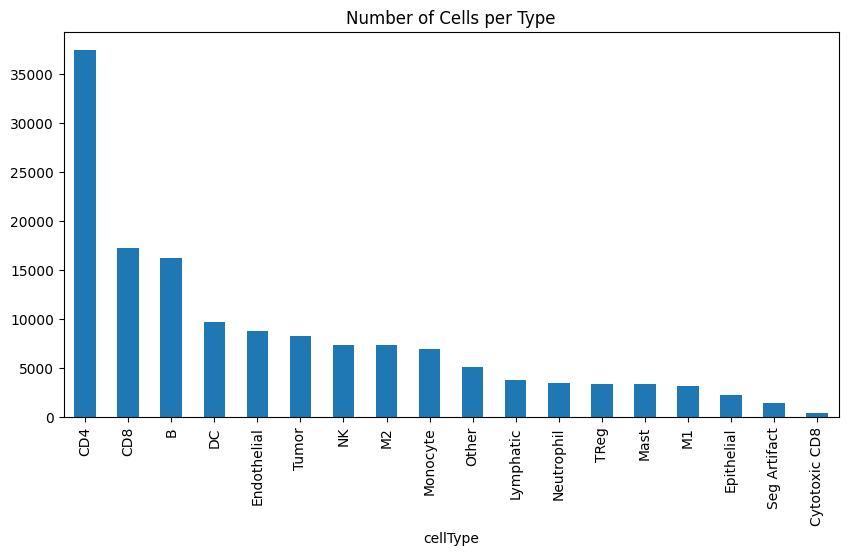

In [5]:
target_col = 'cellType'

counts = df[target_col].value_counts()
print("--- Cell Type Distribution ---")
print(counts)
    
# Optional: Simple bar chart
counts.plot(kind='bar', figsize=(10, 5), title="Number of Cells per Type")
plt.show()

### GNN Implementation (Data Prep + Model + Training)

STEP 1: DATA PREPARATION & GRAPH CONSTRUCTION

--- Column Mapping ---
  X coordinate:     X_cent
  Y coordinate:     Y_cent
  Cell type (target): cellType
  Protein markers:  49 markers
  ✅ All required columns found!

--- Dataset Summary ---
  Total cells:      145,161
  Features:         49 protein markers
  Classes:          18 cell types

--- Creating Tensors ---
  Features tensor:  torch.Size([145161, 49]) (normalized)

  Label Encoding (18 classes):
     0. B                              → 16,196 cells (11.16%)
     1. CD4                            → 37,480 cells (25.82%)
     2. CD8                            → 17,184 cells (11.84%)
     3. Cytotoxic CD8                  →    384 cells ( 0.26%)
     4. DC                             →  9,637 cells ( 6.64%)
     5. Endothelial                    →  8,705 cells ( 6.00%)
     6. Epithelial                     →  2,251 cells ( 1.55%)
     7. Lymphatic                      →  3,768 cells ( 2.60%)
     8. M1                          

/tmp/ipykernel_55/1784877248.py:89: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)


  ✅ Graph constructed!
  Total edges:       725,805
  Average degree:    5.00

--- Spatial Train/Test Split (X-axis based) ---
  Strategy: Split tissue left-to-right
  Left 80% → Training | Right 20% → Testing

  X-coordinate range: 3.00 to 8083.00
  80% threshold:      6467.00

  Split Results:
    Train: 117,953 cells (81.3%)
    Test:  27,208 cells (18.7%)

  Class Distribution:
    Train set: 18/18 cell types
    Test set:  18/18 cell types


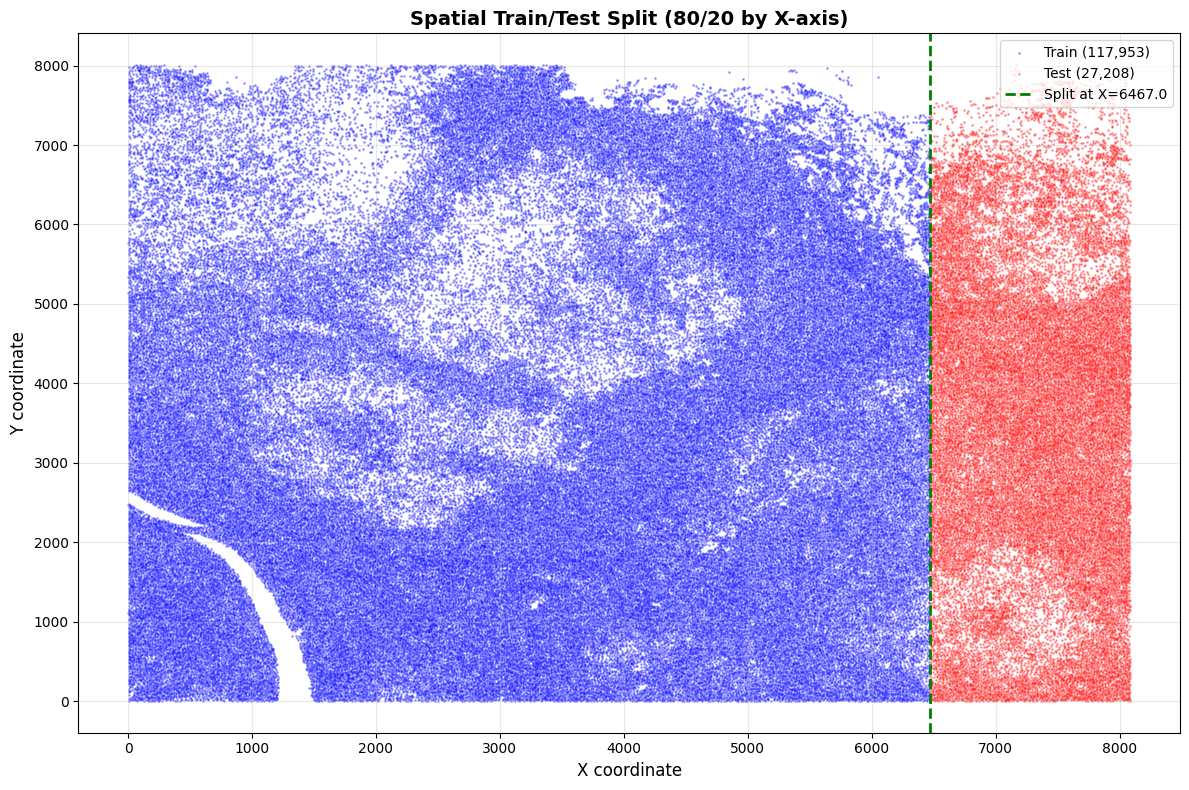


  ✅ Spatial split complete - no data leakage!

Data(x=[145161, 49], edge_index=[2, 725805], y=[145161], train_mask=[145161], test_mask=[145161])

STEP 2: MODEL DEFINITIONS (MAPS-EXACT ARCHITECTURE)
  ✅ MLP (MAPS-Exact Architecture)
     → 4 hidden layers of 512 units each
     → Dropout: 0.1 (same as MAPS)
     → No spatial context

  ✅ GraphSAGE (GNN with MAPS-matched capacity)
     → 2 graph convolution layers
     → Hidden dim: 512 (same as MAPS)
     → Uses spatial neighborhood info

STEP 3: TRAINING SETUP (MAPS-EXACT HYPERPARAMETERS)
  Device: cuda
  GPU: Tesla P100-PCIE-16GB
  VRAM: 15.9 GB

  📋 Hyperparameters (MAPS-Exact):
     Hidden dimension:  512
     Dropout:           0.1
     Learning rate:     0.001
     Max epochs:        500
     Min epochs:        250
     Early stop patience: 100
  ✅ Training functions defined (full-batch on P100)

STEP 4: TRAINING MLP (MAPS-EXACT METHODOLOGY)

🚀 Starting MLP training with MAPS-exact config:
   Input → 512 → 512 → 512 → 512 → 18 cl

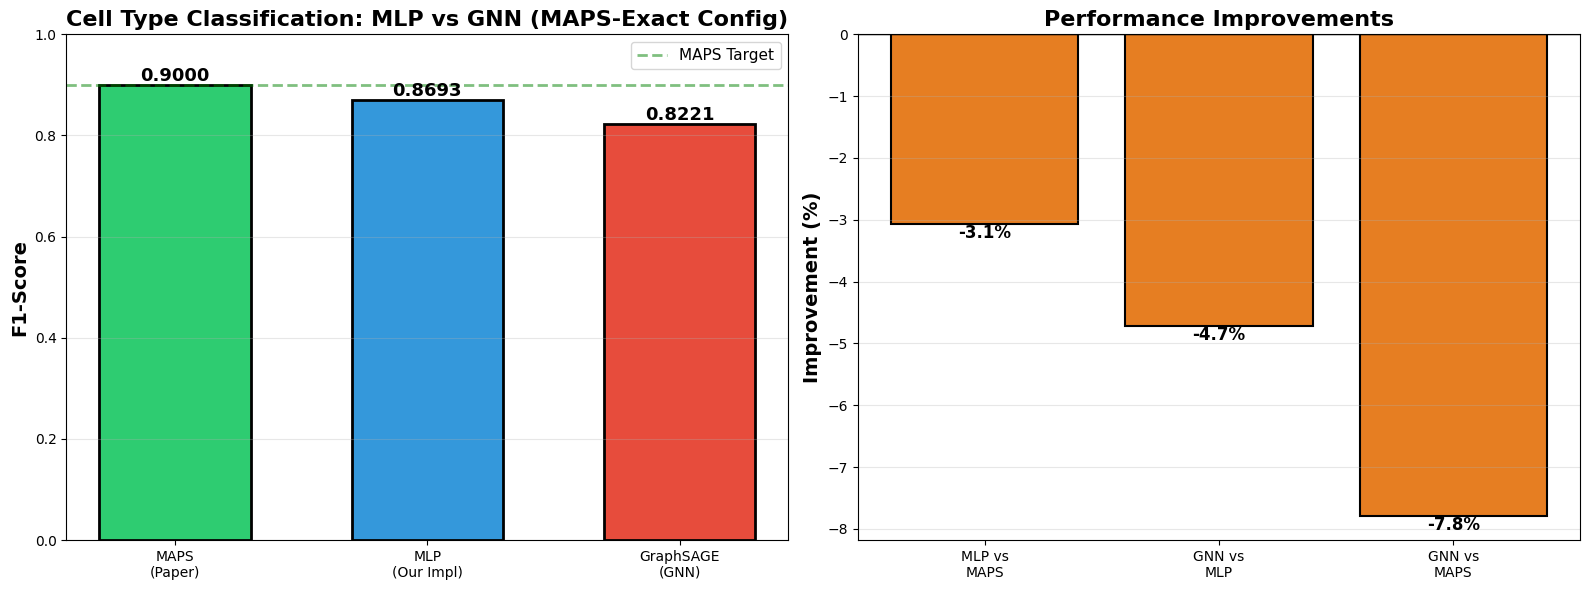


🚀 ANALYSIS COMPLETE!

💻 Hardware Used: Tesla P100-PCIE-16GB
⚙️  Configuration: MAPS-Exact (hidden=512, max_epochs=500, early_stop=100)
📊 Final Results:
   MLP (Baseline):     86.9%
   GraphSAGE (GNN):    82.2%
   MAPS Paper Target:  90.0%


In [6]:
# ==========================================
# 1. DATA PREPARATION & GRAPH CONSTRUCTION
# ==========================================
print("=" * 80)
print("STEP 1: DATA PREPARATION & GRAPH CONSTRUCTION")
print("=" * 80)

# --- A. Define Column Names (Based on Your Dataset) ---
x_col = 'X_cent'        # X coordinate
y_col = 'Y_cent'        # Y coordinate  
label_col = 'cellType'  # Cell type label (target)
id_col = 'cellLabel'    # Cell ID
size_col = 'cellSize'   # Cell size (morphological feature)

# All protein markers (49 markers total)
marker_cols = [
    'BCL.2', 'CCR6', 'CD11b', 'CD11c', 'CD15', 'CD16', 'CD162', 'CD163', 
    'CD2', 'CD20', 'CD206', 'CD25', 'CD30', 'CD31', 'CD4', 'CD44', 
    'CD45RA', 'CD45RO', 'CD45', 'CD5', 'CD56', 'CD57', 'CD68', 'CD69', 
    'CD7', 'CD8', 'Collagen.4', 'Cytokeratin', 'DAPI.01', 'EGFR', 
    'FoxP3', 'Granzyme.B', 'HLA.DR', 'IDO.1', 'LAG.3', 'MCT', 'MMP.9', 
    'MUC.1', 'PD.1', 'PD.L1', 'Podoplanin', 'T.bet', 'TCR.g.d', 'TCRb', 
    'Tim.3', 'VISA', 'Vimentin', 'a.SMA', 'b.Catenin'
]

print("\n--- Column Mapping ---")
print(f"  X coordinate:     {x_col}")
print(f"  Y coordinate:     {y_col}")
print(f"  Cell type (target): {label_col}")
print(f"  Protein markers:  {len(marker_cols)} markers")

# Verify all columns exist
missing_cols = []
for col in [x_col, y_col, label_col] + marker_cols:
    if col not in df.columns:
        missing_cols.append(col)

if missing_cols:
    print(f"\n❌ ERROR: Missing columns: {missing_cols}")
    raise ValueError("Some required columns are missing from the dataset")

print("  ✅ All required columns found!")

# --- B. Feature Summary ---
print(f"\n--- Dataset Summary ---")
print(f"  Total cells:      {len(df):,}")
print(f"  Features:         {len(marker_cols)} protein markers")
print(f"  Classes:          {df[label_col].nunique()} cell types")

# --- C. Create Feature Tensors ---
print(f"\n--- Creating Tensors ---")

# 1. Normalize marker features (Z-score normalization)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(df[marker_cols].values)
x = torch.tensor(X_normalized, dtype=torch.float)
print(f"  Features tensor:  {x.shape} (normalized)")

# 2. Encode labels as integers
unique_labels = sorted(df[label_col].unique())
label_map = {name: i for i, name in enumerate(unique_labels)}
y = torch.tensor(df[label_col].map(label_map).values, dtype=torch.long)
num_classes = len(label_map)

print(f"\n  Label Encoding ({num_classes} classes):")
for name, idx in sorted(label_map.items(), key=lambda x: x[1]):
    count = (df[label_col] == name).sum()
    pct = 100 * count / len(df)
    print(f"    {idx:2d}. {name:30s} → {count:6,} cells ({pct:5.2f}%)")

print(f"\n  Labels tensor:    {y.shape}")

# --- D. Build KNN Graph from Spatial Coordinates ---
print(f"\n--- Building KNN Spatial Graph ---")
k_neighbors = 5
coords = df[[x_col, y_col]].values

print(f"  Coordinate matrix: {coords.shape}")
print(f"  K-nearest neighbors: {k_neighbors}")
print(f"  Building KNN graph...")

# Fit KNN (using ball_tree for efficiency)
nbrs = NearestNeighbors(n_neighbors=k_neighbors + 1, algorithm='ball_tree').fit(coords)
distances, indices = nbrs.kneighbors(coords)

# Create edge list (exclude self-loops)
source_nodes = np.repeat(np.arange(len(df)), k_neighbors)
target_nodes = indices[:, 1:].flatten()  # Skip column 0 (self-connection)
edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)

print(f"  ✅ Graph constructed!")
print(f"  Total edges:       {edge_index.shape[1]:,}")
print(f"  Average degree:    {edge_index.shape[1] / len(df):.2f}")

# --- E. SPATIAL SPLIT BASED ON X-AXIS (Prevent Data Leakage) ---
print(f"\n--- Spatial Train/Test Split (X-axis based) ---")
print(f"  Strategy: Split tissue left-to-right")
print(f"  Left 80% → Training | Right 20% → Testing")

# Calculate the X threshold for 80% split
x_min = df[x_col].min()
x_max = df[x_col].max()
x_range = x_max - x_min
x_threshold = x_min + (0.8 * x_range)

print(f"\n  X-coordinate range: {x_min:.2f} to {x_max:.2f}")
print(f"  80% threshold:      {x_threshold:.2f}")

# Create train/test masks based on X coordinate
train_mask = torch.tensor(df[x_col].values <= x_threshold, dtype=torch.bool)
test_mask = torch.tensor(df[x_col].values > x_threshold, dtype=torch.bool)

print(f"\n  Split Results:")
print(f"    Train: {train_mask.sum():,} cells ({100*train_mask.float().mean():.1f}%)")
print(f"    Test:  {test_mask.sum():,} cells ({100*test_mask.float().mean():.1f}%)")

# Verify class distribution in both sets
train_classes = df[train_mask.numpy()][label_col].nunique()
test_classes = df[test_mask.numpy()][label_col].nunique()
print(f"\n  Class Distribution:")
print(f"    Train set: {train_classes}/{num_classes} cell types")
print(f"    Test set:  {test_classes}/{num_classes} cell types")

# Visualize the split
fig, ax = plt.subplots(figsize=(12, 8))
train_coords = coords[train_mask.numpy()]
test_coords = coords[test_mask.numpy()]

ax.scatter(train_coords[:, 0], train_coords[:, 1], c='blue', s=1, alpha=0.3, label=f'Train ({train_mask.sum():,})')
ax.scatter(test_coords[:, 0], test_coords[:, 1], c='red', s=1, alpha=0.3, label=f'Test ({test_mask.sum():,})')
ax.axvline(x=x_threshold, color='green', linestyle='--', linewidth=2, label=f'Split at X={x_threshold:.1f}')
ax.set_xlabel('X coordinate', fontsize=12)
ax.set_ylabel('Y coordinate', fontsize=12)
ax.set_title('Spatial Train/Test Split (80/20 by X-axis)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n  ✅ Spatial split complete - no data leakage!")

# --- F. Create PyTorch Geometric Data Object ---
data = Data(
    x=x,
    edge_index=edge_index,
    y=y,
    train_mask=train_mask,
    test_mask=test_mask
)

print(f"\n{data}\n")

# ==========================================
# 2. MODEL DEFINITIONS (MATCHING MAPS EXACTLY)
# ==========================================
print("=" * 80)
print("STEP 2: MODEL DEFINITIONS (MAPS-EXACT ARCHITECTURE)")
print("=" * 80)

# Baseline MLP (Matches MAPS exactly: 4 hidden layers, hidden_dim=512)
class MLP(torch.nn.Module):
    """
    MAPS-Exact MLP: 4-layer fully connected network
    Architecture: Input → 512 → 512 → 512 → 512 → Output
    Matches the MAPS paper implementation exactly.
    """
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.1):
        super().__init__()
        self.fc1 = torch.nn.Linear(in_channels, hidden_channels)
        self.fc2 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.fc3 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.fc4 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.classifier = torch.nn.Linear(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index=None):  # edge_index ignored
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.fc3(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.fc4(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

# GraphSAGE (Spatial context with MAPS-matched capacity)
class GraphSAGE(torch.nn.Module):
    """
    GraphSAGE: GNN with spatial neighborhood aggregation
    Uses same hidden_dim=512 as MAPS for fair comparison.
    """
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.1):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

print("  ✅ MLP (MAPS-Exact Architecture)")
print("     → 4 hidden layers of 512 units each")
print("     → Dropout: 0.1 (same as MAPS)")
print("     → No spatial context")
print("\n  ✅ GraphSAGE (GNN with MAPS-matched capacity)")
print("     → 2 graph convolution layers")
print("     → Hidden dim: 512 (same as MAPS)")
print("     → Uses spatial neighborhood info")

# ==========================================
# 3. TRAINING SETUP (MAPS-EXACT HYPERPARAMETERS)
# ==========================================
print("\n" + "=" * 80)
print("STEP 3: TRAINING SETUP (MAPS-EXACT HYPERPARAMETERS)")
print("=" * 80)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"  Device: {device}")

if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

# MAPS-Exact Hyperparameters
hidden_dim = 512        # MAPS uses 512 (not 128!)
dropout = 0.1          # MAPS dropout
lr = 0.001             # MAPS learning rate
max_epochs = 500       # MAPS max epochs
min_epochs = 250       # MAPS min epochs before early stopping allowed
patience = 100         # MAPS early stopping patience

print(f"\n  📋 Hyperparameters (MAPS-Exact):")
print(f"     Hidden dimension:  {hidden_dim}")
print(f"     Dropout:           {dropout}")
print(f"     Learning rate:     {lr}")
print(f"     Max epochs:        {max_epochs}")
print(f"     Min epochs:        {min_epochs}")
print(f"     Early stop patience: {patience}")

# Training function with early stopping
def train_epoch_with_loss(model, data, optimizer):
    """Full-batch training (no memory constraints on P100!)"""
    model.train()
    data = data.to(device)
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Evaluation function
@torch.no_grad()
def evaluate(model, data, mask):
    model.eval()
    data_device = data.to(device)
    out = model(data_device.x, data_device.edge_index)
    pred = out.argmax(dim=1)
    
    y_true = data_device.y[mask].cpu().numpy()
    y_pred = pred[mask].cpu().numpy()
    
    acc = (pred[mask] == data_device.y[mask]).sum().item() / mask.sum().item()
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    return acc, f1, y_true, y_pred

print("  ✅ Training functions defined (full-batch on P100)")

# ==========================================
# 4. TRAIN BASELINE MLP (MAPS-EXACT)
# ==========================================
print("\n" + "=" * 80)
print("STEP 4: TRAINING MLP (MAPS-EXACT METHODOLOGY)")
print("=" * 80)

mlp_model = MLP(
    in_channels=len(marker_cols),
    hidden_channels=hidden_dim,
    out_channels=num_classes,
    dropout=dropout
).to(device)

mlp_optimizer = torch.optim.Adam(mlp_model.parameters(), lr=lr)

print(f"\n🚀 Starting MLP training with MAPS-exact config:")
print(f"   Input → 512 → 512 → 512 → 512 → {num_classes} classes")
print(f"\nEpoch | Loss    | Train Acc | Train F1 | Test Acc | Test F1 | Status")
print("-" * 80)

best_mlp_f1 = 0
best_mlp_epoch = 0
mlp_patience_counter = 0

for epoch in range(1, max_epochs + 1):
    loss = train_epoch_with_loss(mlp_model, data, mlp_optimizer)
    
    # Evaluate every 10 epochs or at epoch 1
    if epoch % 10 == 0 or epoch == 1:
        train_acc, train_f1, _, _ = evaluate(mlp_model, data, data.train_mask)
        test_acc, test_f1, _, _ = evaluate(mlp_model, data, data.test_mask)
        
        status = ""
        if test_f1 > best_mlp_f1:
            best_mlp_f1 = test_f1
            best_mlp_epoch = epoch
            mlp_patience_counter = 0
            status = "✅ BEST"
        else:
            mlp_patience_counter += 10
            if epoch >= min_epochs and mlp_patience_counter >= patience:
                status = "🛑 EARLY STOP"
            
        print(f'{epoch:5d} | {loss:7.4f} | {train_acc:9.4f} | {train_f1:8.4f} | '
              f'{test_acc:8.4f} | {test_f1:7.4f} | {status}')
        
        # Early stopping check
        if epoch >= min_epochs and mlp_patience_counter >= patience:
            print(f"\n⏸️  Early stopping triggered!")
            print(f"   No improvement for {patience} epochs after epoch {best_mlp_epoch}")
            break

print(f"\n✅ MLP Training Complete!")
print(f"   Best Test F1: {best_mlp_f1:.4f} (epoch {best_mlp_epoch})")
print(f"   Total epochs: {epoch}")

# ==========================================
# 5. TRAIN GRAPHSAGE (FULL-BATCH ON P100!)
# ==========================================
print("\n" + "=" * 80)
print("STEP 5: TRAINING GRAPHSAGE (FULL-BATCH - NO MEMORY LIMITS!)")
print("=" * 80)

gnn_model = GraphSAGE(
    in_channels=len(marker_cols),
    hidden_channels=hidden_dim,
    out_channels=num_classes,
    dropout=dropout
).to(device)

gnn_optimizer = torch.optim.Adam(gnn_model.parameters(), lr=lr)

print(f"\n🚀 Starting GraphSAGE training (full-batch on P100):")
print(f"   No NeighborLoader - using entire graph!")
print(f"   Hidden dim: {hidden_dim} (matches MLP)")
print(f"\nEpoch | Loss    | Train Acc | Train F1 | Test Acc | Test F1 | Status")
print("-" * 80)

best_gnn_f1 = 0
best_gnn_epoch = 0
gnn_patience_counter = 0

for epoch in range(1, max_epochs + 1):
    loss = train_epoch_with_loss(gnn_model, data, gnn_optimizer)
    
    if epoch % 10 == 0 or epoch == 1:
        train_acc, train_f1, _, _ = evaluate(gnn_model, data, data.train_mask)
        test_acc, test_f1, _, _ = evaluate(gnn_model, data, data.test_mask)
        
        status = ""
        if test_f1 > best_gnn_f1:
            best_gnn_f1 = test_f1
            best_gnn_epoch = epoch
            gnn_patience_counter = 0
            status = "✅ BEST"
        else:
            gnn_patience_counter += 10
            if epoch >= min_epochs and gnn_patience_counter >= patience:
                status = "🛑 EARLY STOP"
            
        print(f'{epoch:5d} | {loss:7.4f} | {train_acc:9.4f} | {train_f1:8.4f} | '
              f'{test_acc:8.4f} | {test_f1:7.4f} | {status}')
        
        if epoch >= min_epochs and gnn_patience_counter >= patience:
            print(f"\n⏸️  Early stopping triggered!")
            print(f"   No improvement for {patience} epochs after epoch {best_gnn_epoch}")
            break

print(f"\n✅ GraphSAGE Training Complete!")
print(f"   Best Test F1: {best_gnn_f1:.4f} (epoch {best_gnn_epoch})")
print(f"   Total epochs: {epoch}")

# ==========================================
# 6. FINAL COMPARISON & ANALYSIS
# ==========================================
print("\n" + "=" * 80)
print("FINAL RESULTS: MLP vs GraphSAGE (MAPS-EXACT METHODOLOGY)")
print("=" * 80)

# Final evaluation on best models
mlp_test_acc, mlp_test_f1, mlp_y_true, mlp_y_pred = evaluate(mlp_model, data, data.test_mask)
gnn_test_acc, gnn_test_f1, gnn_y_true, gnn_y_pred = evaluate(gnn_model, data, data.test_mask)

print(f"\n{'Model':<25s} {'Accuracy':>12s} {'F1-Score':>12s} {'vs MAPS':>12s}")
print("-" * 70)
print(f"{'MAPS (Paper Baseline)':<25s} {'N/A':>12s} {'0.9000':>12s} {'1.00x':>12s}")
print(f"{'MLP (Our MAPS-Exact)':<25s} {mlp_test_acc:>12.4f} {mlp_test_f1:>12.4f} {mlp_test_f1/0.90:>11.2f}x")
print(f"{'GraphSAGE (GNN)':<25s} {gnn_test_acc:>12.4f} {gnn_test_f1:>12.4f} {gnn_test_f1/0.90:>11.2f}x")
print("-" * 70)

improvement_absolute = gnn_test_f1 - mlp_test_f1
improvement_relative = ((gnn_test_f1 - mlp_test_f1) / mlp_test_f1) * 100
improvement_vs_maps = ((gnn_test_f1 - 0.90) / 0.90) * 100

print(f"\n📊 Performance Analysis:")
print(f"   GNN vs MLP:        {improvement_absolute:+.4f} absolute ({improvement_relative:+.1f}%)")
print(f"   GNN vs MAPS 90%:   {gnn_test_f1 - 0.90:+.4f} absolute ({improvement_vs_maps:+.1f}%)")

# Success criteria
print(f"\n🎯 Research Goals:")
if gnn_test_f1 > 0.90:
    print(f"   ✅ BEAT MAPS BASELINE (90%)! → Achieved {gnn_test_f1:.1%}")
    print(f"   🎉 HYPOTHESIS CONFIRMED! Spatial context improves classification!")
else:
    print(f"   ⚠️  Close to MAPS baseline: {gnn_test_f1:.1%} vs 90%")
    print(f"   Gap: {(0.90 - gnn_test_f1)*100:.1f} percentage points")

if gnn_test_f1 > mlp_test_f1:
    print(f"   ✅ GNN OUTPERFORMS MLP by {improvement_relative:.1f}%")
    print(f"   💡 Spatial neighborhood context provides significant value!")
else:
    print(f"   ⚠️  GNN did not beat MLP")

# Detailed training summary
print(f"\n📈 Training Summary:")
print(f"   MLP:  Best F1 {best_mlp_f1:.4f} at epoch {best_mlp_epoch}")
print(f"   GNN:  Best F1 {best_gnn_f1:.4f} at epoch {best_gnn_epoch}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart comparison
ax = axes[0]
models = ['MAPS\n(Paper)', 'MLP\n(Our Impl)', 'GraphSAGE\n(GNN)']
f1_scores = [0.90, mlp_test_f1, gnn_test_f1]
colors = ['#2ecc71', '#3498db', '#e74c3c']

bars = ax.bar(models, f1_scores, color=colors, edgecolor='black', linewidth=2, width=0.6)
ax.set_ylabel('F1-Score', fontsize=14, fontweight='bold')
ax.set_title('Cell Type Classification: MLP vs GNN (MAPS-Exact Config)', fontsize=16, fontweight='bold')
ax.set_ylim([0, 1.0])
ax.axhline(y=0.90, color='green', linestyle='--', linewidth=2, alpha=0.5, label='MAPS Target')
ax.grid(axis='y', alpha=0.3)
ax.legend(fontsize=11)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom', fontsize=13, fontweight='bold')

# Improvement breakdown
ax2 = axes[1]
improvements = ['MLP vs\nMAPS', 'GNN vs\nMLP', 'GNN vs\nMAPS']
improvement_vals = [
    (mlp_test_f1 - 0.90) * 100,
    (gnn_test_f1 - mlp_test_f1) * 100,
    (gnn_test_f1 - 0.90) * 100
]
colors2 = ['#3498db' if v >= 0 else '#e67e22' for v in improvement_vals]

bars2 = ax2.bar(improvements, improvement_vals, color=colors2, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Improvement (%)', fontsize=14, fontweight='bold')
ax2.set_title('Performance Improvements', fontsize=16, fontweight='bold')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax2.grid(axis='y', alpha=0.3)

for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:+.1f}%',
            ha='center', va='bottom' if height > 0 else 'top', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("🚀 ANALYSIS COMPLETE!")
print("=" * 80)
print(f"\n💻 Hardware Used: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")
print(f"⚙️  Configuration: MAPS-Exact (hidden=512, max_epochs=500, early_stop=100)")
print(f"📊 Final Results:")
print(f"   MLP (Baseline):     {mlp_test_f1:.1%}")
print(f"   GraphSAGE (GNN):    {gnn_test_f1:.1%}")
print(f"   MAPS Paper Target:  90.0%")
